In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import wilcoxon
import matplotlib.ticker as ticker

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'x', '+', '*']
palette_model = {
    'ae': 'blue',
    'svdd': 'green',
    'if': 'brown',
    'lof': 'lime',
    'ocsvm': 'cyan',
    'dagmm': 'magenta',
    'alad': 'orange',
    'dsebm': 'purple',
    
    'Bopeto_if': 'lime',
    'Bopeto_lof': 'brown',
    'Bopeto_ocsvm': 'indigo',
    'Bopeto_dagmm': 'violet',
    'Bopeto_alad': 'gray',
    'Bopeto_dsebm': 'black',
    
    'iad_ae': 'red',
    'Bopeto_ae': 'blue',
    'iad_svdd': 'purple',
    'Bopeto_svdd': 'green',
    'iad_Bopeto_ae': 'blue',
    'iad_Bopeto_svdd': 'green',
}
palette_dataset = {
    'ciciot': 'red',
    'credit': 'green',
    'ecg': 'blue',
    'ids': 'purple',
    'kdd': 'cyan',
    'kitsune': 'magenta'
}
palette_instance = {
    'out': 'red',
    'synthetic': 'green',
    'in': 'blue'
}
instance_mapping = {
    0.0: 'in',
    1.0: 'out',
    2.0: 'synthetic'
}

false_mapping = {
    0: 'tn',
    1: 'tp',
    2: 'fp',
    3:'fn'
}

false_mapping_reverse = {
    'tn': 0,
    'tp': 1,
    'fp': 2,
    'fn':3
}

false_palette = {
    'tn':'blue',
    'tp':'red',
    'fp':'orange',
    'fn':'cyan'
}

datasets = list(palette_dataset.keys())
models = palette_model.keys()
base_models = list(filter(lambda x: "Bopeto" not in x, models))
bopeto_models = list(filter(lambda x: "Bopeto" in x, models))
instances = palette_instance.keys()
performance_metrics = ["f1", "accuracy", "precision", "recall"]

### Error bars

In [3]:
def fp(df):
    n = df.loc[df['r1']==0.,'n1'].values[0]
    df['fp'] = 1-df['n2']*(1-df['r2'])/n

In [4]:
ciciot_run = pd.read_csv("ciciot_run.csv")
fp(ciciot_run)
credit_run = pd.read_csv("credit_run.csv")
fp(credit_run)
ecg_run = pd.read_csv("ecg_run.csv")
fp(ecg_run)
ids_run = pd.read_csv("ids_run.csv")
fp(ids_run)
kdd_run = pd.read_csv("kdd_run.csv")
fp(kdd_run)
kitsune_run = pd.read_csv("kitsune_run.csv")
fp(kitsune_run)
runs = [ciciot_run, credit_run, ecg_run, ids_run, kdd_run, kitsune_run]

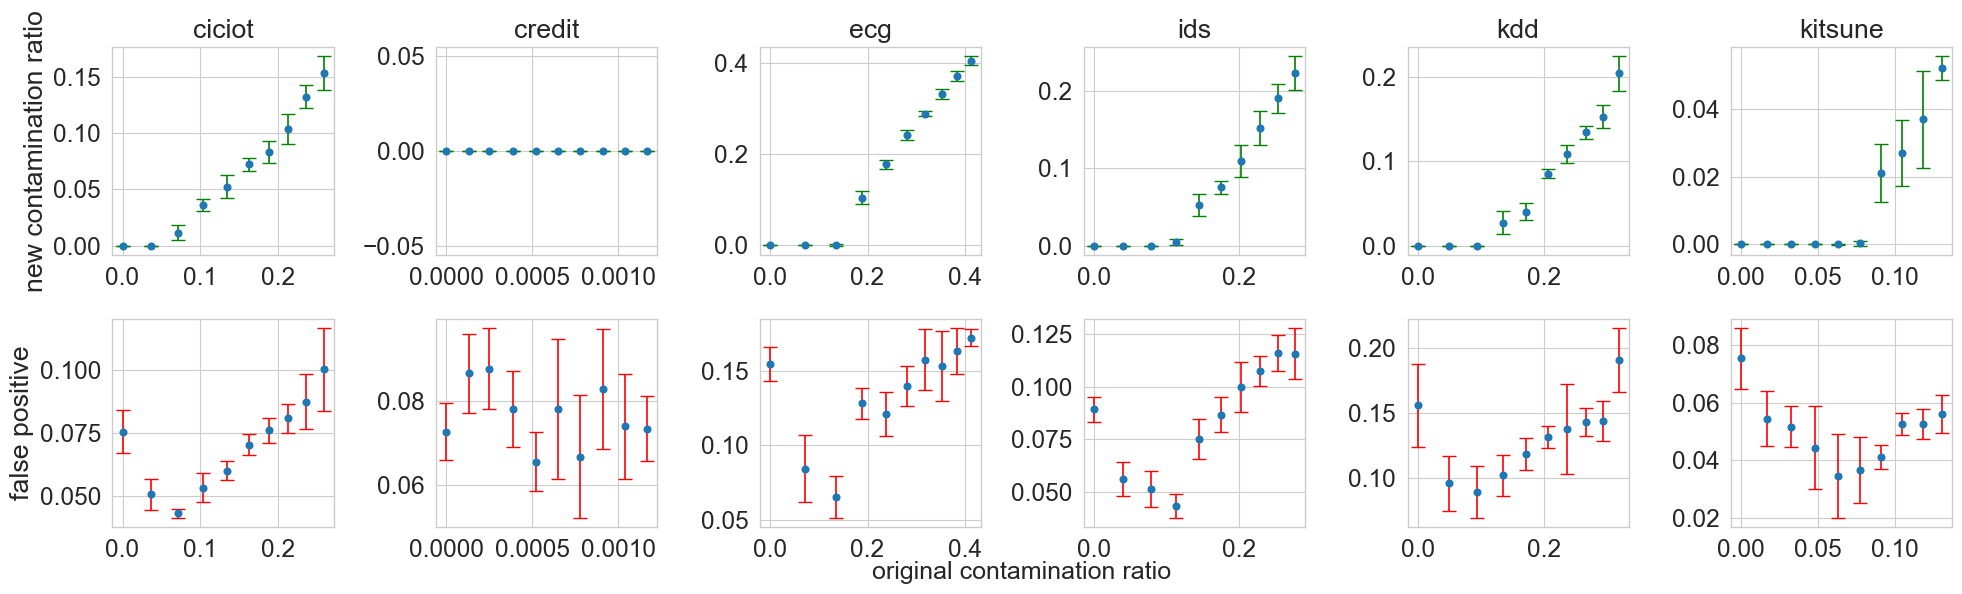

In [5]:
figsize = (20, 6)
sns.set_context("paper", font_scale=2.)  # Adjust font scale
sns.set_style("whitegrid") 
fig, axes = plt.subplots(ncols=6,nrows=2, figsize=figsize, sharey=False)
for i, df in enumerate(runs):
    ax = axes[0, i]
    ax.set_title(f'{datasets[i]}')
    g_df = df.groupby(['r1'])['r2'].agg(['mean', 'std'])
    ax.errorbar(np.round(g_df.index, 5), y=g_df['mean'], yerr=g_df['std'], fmt='o', capsize=5, errorevery=1, ecolor='green')
    ax.set_xlabel(None)
    if i==0:
        ax.set_ylabel('new contamination ratio')
    else:
        ax.set_ylabel(None)
    ax = axes[1, i]
    g_df = df.groupby(['r1'])['fp'].agg(['mean', 'std'])
    ax.errorbar(np.round(g_df.index, 5), y=g_df['mean'], yerr=g_df['std'], fmt='o', capsize=5, errorevery=1, ecolor='red')
    ax.set_xlabel(None)
    if i==0:
        ax.set_ylabel('false positive')
    else:
        ax.set_ylabel(None)
plt.tight_layout()
fig.text(0.52, 0.03, 'original contamination ratio', fontsize=18, ha='center', va='center')
plt.savefig("error_bars.pdf")
plt.show()

### Contamination ratio

In [ ]:
kdd = pd.read_csv("kdd.csv")
ids = pd.read_csv("ids.csv")
ciciot = pd.read_csv("ciciot.csv")
kitsune = pd.read_csv("kitsune.csv")
credit = pd.read_csv("credit.csv")
ecg = pd.read_csv("ecg.csv")

in_kdd = kdd.loc[kdd['r1']==0.,'n1'].values[0]
in_ids = ids.loc[ids['r1']==0.,'n1'].values[0]
in_kitsune = kitsune.loc[kitsune['r1']==0.,'n1'].values[0]
in_ciciot = ciciot.loc[ciciot['r1']==0.,'n1'].values[0]
in_credit = credit.loc[credit['r1']==0.,'n1'].values[0]
in_ecg = ecg.loc[ecg['r1']==0.,'n1'].values[0]


kdd['ratio'] = kdd['n2']*(1-kdd['r2'])/in_kdd
ids['ratio'] = ids['n2']*(1-ids['r2'])/in_ids
ciciot['ratio'] = ciciot['n2']*(1-ciciot['r2'])/in_ciciot
kitsune['ratio'] = kitsune['n2']*(1-kitsune['r2'])/in_kitsune
credit['ratio'] = credit['n2']*(1-credit['r2'])/in_credit
ecg['ratio'] = ecg['n2']*(1-ecg['r2'])/in_ecg

kdd['name'] ='kdd'
credit['name'] ='credit'
ids['name'] = 'ids'
ciciot['name'] ='ciciot'
kitsune['name'] = 'kitsune'
ecg['name'] = 'ecg'
data = pd.concat([kdd, ids, ciciot,kitsune, credit, ecg], ignore_index=True)

In [ ]:
data

In [ ]:
data.rename(columns={'name': 'dataset'}, inplace=True)
eps = 0.0000000000000001
data['improvement'] = 100*(data.r1-data.r2)/(data.r1+eps)
data['id'] = range(len(data))
data = data.sort_values(by=['dataset', 'r1'])
data.loc[data['dataset']=='kdd', 'id'] = range(10)
data.loc[data['dataset']=='ciciot', 'id'] = range(10)
data.loc[data['dataset']=='ids', 'id'] = range(10)
data.loc[data['dataset']=='kitsune', 'id'] = range(10)
data.loc[data['dataset']=='credit', 'id'] = range(10)
data.loc[data['dataset']=='ecg', 'id'] = range(10)
data[data['dataset']=='ecg'].head(12)

In [ ]:
data[data['dataset']=='ecg'].head(40)

In [ ]:
data_cp = data.copy()
data_cp = data_cp[data_cp['r1'] != 0]
data_cp.head(40)

In [ ]:
data_cp[data_cp['dataset']=='ciciot'].head(40)

### Performance metrics

In [ ]:
rep = "../outputs_backup_01/"

### Performance Bopeto

In [6]:
df_1 = pd.read_csv("performances_kdd_ae.csv")
df_2 = pd.read_csv("performances_kdd_ocsvm.csv")
df_3 = pd.read_csv("performances_kdd_lof.csv")
df_4 = pd.read_csv("performances_kdd_if.csv")
df_5 = pd.read_csv("performances_kdd_svdd.csv")
df_6 = pd.read_csv("performances_kdd_dsebm.csv")
df_7 = pd.read_csv("performances_kdd_alad.csv")
df_8 = pd.read_csv("performances_kdd_dagmm.csv")
df_kdd = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0, ignore_index=True)

In [7]:
df_1 = pd.read_csv("performances_kitsune_ae.csv")
df_2 = pd.read_csv("performances_kitsune_ocsvm.csv")
df_3 = pd.read_csv("performances_kitsune_lof.csv")
df_4 = pd.read_csv("performances_kitsune_if.csv")
df_5 = pd.read_csv("performances_kitsune_svdd.csv")
df_6 = pd.read_csv("performances_kitsune_dsebm.csv")
df_7 = pd.read_csv("performances_kitsune_alad.csv")
df_8 = pd.read_csv("performances_kitsune_dagmm.csv")
df_kitsune = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0, ignore_index=True)

In [8]:
df_1 = pd.read_csv("performances_ciciot_ae.csv")
df_2 = pd.read_csv("performances_ciciot_ocsvm.csv")
df_3 = pd.read_csv("performances_ciciot_lof.csv")
df_4 = pd.read_csv("performances_ciciot_if.csv")
df_5 = pd.read_csv("performances_ciciot_svdd.csv")
df_6 = pd.read_csv("performances_ciciot_dsebm.csv")
df_7 = pd.read_csv("performances_ciciot_alad.csv")
df_8 = pd.read_csv("performances_ciciot_dagmm.csv")
df_ciciot = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0, ignore_index=True)

In [9]:
df_1 = pd.read_csv("performances_ids_ae.csv")
df_2 = pd.read_csv("performances_ids_ocsvm.csv")
df_3 = pd.read_csv("performances_ids_lof.csv")
df_4 = pd.read_csv("performances_ids_if.csv")
df_5 = pd.read_csv("performances_ids_svdd.csv")
df_6 = pd.read_csv("performances_ids_dsebm.csv")
df_7 = pd.read_csv("performances_ids_alad.csv")
df_8 = pd.read_csv("performances_ids_dagmm.csv")
df_ids = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0, ignore_index=True)

In [10]:
df_1 = pd.read_csv("performances_ecg_ae.csv")
df_2 = pd.read_csv("performances_ecg_ocsvm.csv")
df_3 = pd.read_csv("performances_ecg_lof.csv")
df_4 = pd.read_csv("performances_ecg_if.csv")
df_5 = pd.read_csv("performances_ecg_svdd.csv")
df_6 = pd.read_csv("performances_ecg_dsebm.csv")
df_7 = pd.read_csv("performances_ecg_alad.csv")
df_8 = pd.read_csv("performances_ecg_dagmm.csv")
df_ecg = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6,df_7,df_8], axis=0, ignore_index=True)

In [11]:
df_1 = pd.read_csv("performances_credit_ae.csv")
df_2 = pd.read_csv("performances_credit_ocsvm.csv")
df_3 = pd.read_csv("performances_credit_lof.csv")
df_4 = pd.read_csv("performances_credit_if.csv")
df_5 = pd.read_csv("performances_credit_svdd.csv")
df_6 = pd.read_csv("performances_credit_dsebm.csv")
df_7 = pd.read_csv("performances_credit_alad.csv")
df_8 = pd.read_csv("performances_credit_dagmm.csv")
df_credit = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0, ignore_index=True)

In [12]:
df_perf = pd.concat([df_ciciot, df_credit, df_ecg, df_ids, df_kdd, df_kitsune], axis=0, ignore_index=True)
df_perf = df_perf[~df_perf['model'].str.contains("ocsvm")]
df_perf = df_perf.sort_values(by='dataset')

df_for_iad = df_perf[df_perf['model'].str.contains("Bopeto_svdd") | df_perf['model'].str.contains("Bopeto_ae")]

### Soft cleaning

In [97]:
df_1 = pd.read_csv("performances_softbopeto_kdd_ae.csv")
df_2 = pd.read_csv("performances_softbopeto_kdd_svdd.csv")
df_kdd_s = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [98]:
df_1 = pd.read_csv("performances_softbopeto_kitsune_ae.csv")
df_2 = pd.read_csv("performances_softbopeto_kitsune_svdd.csv")
df_kitsune_s = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [99]:
df_1 = pd.read_csv("performances_softbopeto_ids_ae.csv")
df_2 = pd.read_csv("performances_softbopeto_ids_svdd.csv")
df_ids_s = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [100]:
df_1 = pd.read_csv("performances_softbopeto_ecg_ae.csv")
df_2 = pd.read_csv("performances_softbopeto_ecg_svdd.csv")
df_ecg_s = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [101]:
df_1 = pd.read_csv("performances_softbopeto_credit_ae.csv")
df_2 = pd.read_csv("performances_softbopeto_credit_svdd.csv")
df_credit_s = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [102]:
df_1 = pd.read_csv("performances_softbopeto_ciciot_ae.csv")
df_2 = pd.read_csv("performances_softbopeto_ciciot_svdd.csv")
df_ciciot_s = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [103]:
df_perf_s = pd.concat([df_ciciot_s, df_credit_s, df_ecg_s, df_ids_s, df_kdd_s, df_kitsune_s], axis=0, ignore_index=True)
df_perf_s = df_perf_s[df_perf_s['model'].str.contains("Bopeto_svdd") | df_perf_s['model'].str.contains("Bopeto_ae")]
df_perf_s = df_perf_s.sort_values(by='dataset')
df_perf_s

,dataset,contamination,model,accuracy,precision,recall,f1
1,ciciot,0.000000,Bopeto_ae,0.674176,0.799022,0.682743,0.736320
39,ciciot,0.257957,Bopeto_svdd,0.532488,0.695304,0.531118,0.602221
37,ciciot,0.236059,Bopeto_svdd,0.551071,0.710111,0.551331,0.620728
35,ciciot,0.212833,Bopeto_svdd,0.542837,0.703337,0.542892,0.612786
33,ciciot,0.188146,Bopeto_svdd,0.509991,0.676517,0.507067,0.579662
...,...,...,...,...,...,...,...
203,kitsune,0.016489,Bopeto_ae,0.700650,0.763014,0.440924,0.558885
201,kitsune,0.000000,Bopeto_ae,0.700791,0.763485,0.440883,0.558978
237,kitsune,0.118281,Bopeto_svdd,0.642139,0.609283,0.468133,0.529462
217,kitsune,0.118281,Bopeto_ae,0.700685,0.763160,0.440883,0.558891


In [104]:
def get_improvement_soft():
    stat_db = pd.DataFrame([])
    for metric in performance_metrics:
        for dataset in datasets:
            for model in ["ae", "svdd"]:
                ds_hard = df_perf[(df_perf["dataset"]==dataset) & (df_perf["model"]=="Bopeto_"+model)]
                ds_soft = df_perf_s[(df_perf_s["dataset"]==dataset) & (df_perf_s["model"]=="Bopeto_"+model)]
                contamination = np.unique(ds_hard["contamination"][(ds_hard["model"]=="Bopeto_"+model) & (ds_hard["dataset"]==dataset)].values)
                diff_soft = []
                for c in contamination:
                    acc_hard = ds_hard.loc[ds_hard['contamination']==c, metric].values[0]
                    acc_soft = ds_soft.loc[ds_soft['contamination']==c, metric].values[0]
                    diff_soft.append(acc_hard - acc_soft)

                diff_soft = pd.DataFrame({"performance": diff_soft})
                diff_soft["contamination"] = contamination
                diff_soft['dataset'] = dataset
                diff_soft['metric'] = metric
                diff_soft["model"] = model
                diff_soft["id"]=range(len(contamination))
                stat_db = pd.concat([stat_db, diff_soft], ignore_index=True)
    return stat_db

In [105]:
diff_soft = get_improvement_soft()
diff_soft = diff_soft.sort_values(by='dataset')
diff_soft

,performance,contamination,dataset,metric,model,id
0,-0.001374,0.000000,ciciot,f1,ae,0
362,0.000744,0.071705,ciciot,recall,ae,2
363,0.001713,0.103842,ciciot,recall,ae,3
364,-0.001946,0.133822,ciciot,recall,ae,4
365,0.002726,0.161866,ciciot,recall,ae,5
...,...,...,...,...,...,...
233,0.059764,0.047898,kitsune,accuracy,svdd,3
232,-0.031047,0.032444,kitsune,accuracy,svdd,2
231,0.074944,0.016489,kitsune,accuracy,svdd,1
229,-0.000088,0.131133,kitsune,accuracy,ae,9


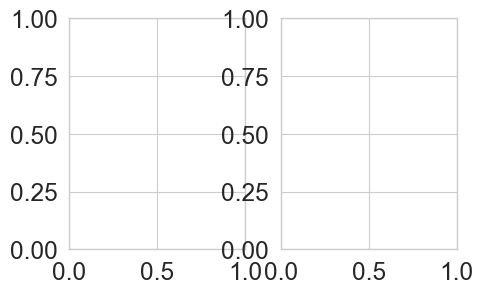

In [106]:
figsize = (5, 3)
sns.set_context("paper", font_scale=2.)  # Adjust font scale
sns.set_style("whitegrid") 
fig, axes = plt.subplots(ncols=2, figsize=figsize, sharey=False)

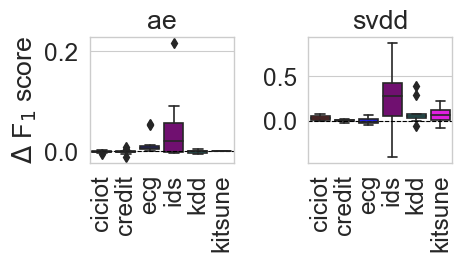

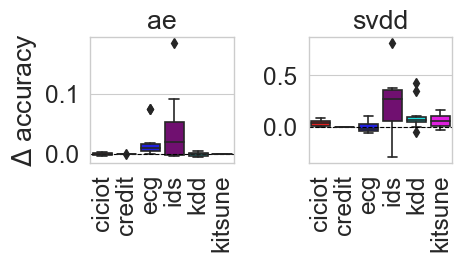

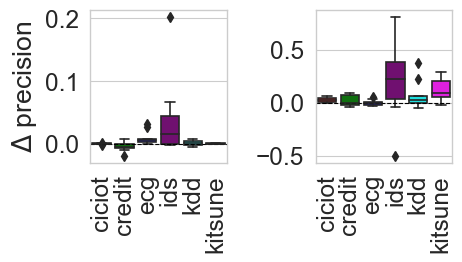

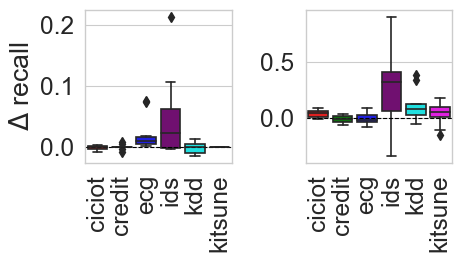

In [107]:
figsize = (5, 3)
sns.set_context("paper", font_scale=2.)  # Adjust font scale
sns.set_style("whitegrid") 
k = True
for metric in performance_metrics:
    diff = diff_soft[diff_soft["metric"]==metric].sort_values(by=['dataset','contamination'])
    fig, axes = plt.subplots(ncols=2, figsize=figsize, sharey=False)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, diff.groupby('model'))):
        sns.boxplot(data=df_group, x=df_group.dataset, y="performance", ax=ax, palette=palette_dataset)
        if metric in ["f1", "accuracy"]:
            ax.set_title(f'{subplot}')
        ax.set_xlabel('')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        #ax.set_xticks([])
        #ax.set_xticklabels(labels=sorted_data['category'].unique(), rotation=90)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        if i==0:
            if metric=="f1":
                ax.set_ylabel(r'$\Delta$ F$_1$ score')
                #fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.09), ncol=6, fontsize='large')
                fig.tight_layout()
            else: 
                if i == 0:
                    ax.set_ylabel(r'$\Delta$ {}'.format(metric))
        else:
            ax.set_ylabel('')
        #ax.legend().remove()
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    if k:
        pass
        #fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.21), ncol=6)
    k = False
    plt.tight_layout()
    plt.savefig(metric+"_boxplot_soft_difference.pdf")
    plt.show()

### Performance IAD

In [108]:
pd.options.mode.copy_on_write = True 
df_for_iad.head()

,dataset,contamination,model,accuracy,precision,recall,f1
93,ciciot,0.188146,Bopeto_svdd,0.567318,0.722861,0.568665,0.636558
95,ciciot,0.212833,Bopeto_svdd,0.599812,0.746827,0.604249,0.668015
97,ciciot,0.236059,Bopeto_svdd,0.544259,0.704634,0.544121,0.614061
99,ciciot,0.257957,Bopeto_svdd,0.591781,0.741359,0.594905,0.660106
91,ciciot,0.161866,Bopeto_svdd,0.472089,0.643320,0.466210,0.540629


In [109]:
df_1 = pd.read_csv("performances__iad_ciciot_ae.csv")
df_2 = pd.read_csv("performances__iad_ciciot_svdd.csv")
df_iad_ciciot = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [110]:
df_1 = pd.read_csv("performances__iad_credit_ae.csv")
df_2 = pd.read_csv("performances__iad_credit_svdd.csv")
df_iad_credit = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [111]:
df_1 = pd.read_csv("performances__iad_ecg_ae.csv")
df_2 = pd.read_csv("performances__iad_ecg_svdd.csv")
df_iad_ecg = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [112]:
df_1 = pd.read_csv("performances__iad_ids_ae.csv")
df_2 = pd.read_csv("performances__iad_ids_svdd.csv")
df_iad_ids = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [113]:
df_1 = pd.read_csv("performances__iad_kdd_ae.csv")
df_2 = pd.read_csv("performances__iad_kdd_svdd.csv")
df_iad_kdd = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [114]:
df_1 = pd.read_csv("performances__iad_kitsune_ae.csv")
df_2 = pd.read_csv("performances__iad_kitsune_svdd.csv")
df_iad_kitsune = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [115]:
df_iad = pd.concat([df_iad_ciciot, df_iad_credit, df_iad_ecg, df_iad_ids,
                    df_iad_kdd, df_iad_kitsune], axis=0, ignore_index=True)
df_iad['model'] = df_iad['model'].apply(lambda x: "iad_" + str(x))
df_iad = pd.concat([df_iad, df_for_iad], axis=0, ignore_index=True)
df_iad = df_iad.sort_values(by='dataset')

In [116]:
df_iad

,dataset,contamination,model,accuracy,precision,recall,f1
0,ciciot,0.000000,iad_ae,0.666408,0.794755,0.673210,0.728951
32,ciciot,0.188146,iad_svdd,0.534191,0.697202,0.531961,0.603474
33,ciciot,0.188146,iad_Bopeto_svdd,0.589738,0.740685,0.591309,0.657621
34,ciciot,0.212833,iad_svdd,0.510708,0.677388,0.507282,0.580122
35,ciciot,0.212833,iad_Bopeto_svdd,0.596084,0.745042,0.598689,0.663896
...,...,...,...,...,...,...,...
215,kitsune,0.105051,iad_Bopeto_ae,0.700702,0.763214,0.440883,0.558905
216,kitsune,0.118281,iad_ae,0.700579,0.762872,0.440842,0.558781
217,kitsune,0.118281,iad_Bopeto_ae,0.700667,0.763106,0.440883,0.558876
239,kitsune,0.131133,iad_Bopeto_svdd,0.765938,0.852975,0.550704,0.669293


In [117]:
def get_improvement():
    stat_db_iad = pd.DataFrame([])
    stat_db_b_iad = pd.DataFrame([])
    for metric in performance_metrics:
        for dataset in datasets:
            for model in ["ae", "svdd"]:
                ds_iad = df_iad[(df_iad["dataset"]==dataset) & (df_iad["model"]=="iad_"+model)]
                ds_b = df_iad[(df_iad["dataset"]==dataset) & (df_iad["model"]=="Bopeto_"+model)]
                ds_b_iad = df_iad[(df_iad["dataset"]==dataset) & (df_iad["model"]=="iad_Bopeto_"+model)]
                contamination = np.unique(ds_iad["contamination"][(ds_iad["model"]=="iad_"+model) & (ds_iad["dataset"]==dataset)].values)
                diff_iad = []
                diff_b_iad = []
                for c in contamination:
                    acc_iad = ds_iad.loc[ds_iad['contamination']==c, metric].values[0]
                    acc_b = ds_b.loc[ds_b['contamination']==c, metric].values[0]
                    acc_b_iad = ds_b_iad.loc[ds_b_iad['contamination']==c, metric].values[0]
                    diff_iad.append(acc_b - acc_iad)
                    diff_b_iad.append(acc_b_iad - acc_iad)

                diff_iad = pd.DataFrame({"performance": diff_iad})
                diff_b_iad = pd.DataFrame({"performance": diff_b_iad})
                diff_iad["contamination"] = contamination
                diff_iad['dataset'] = dataset
                diff_iad['metric'] = metric
                diff_iad["model"] = "bopeto vs iad on "+model
                diff_b_iad["contamination"] = contamination
                diff_b_iad['dataset'] = dataset
                diff_b_iad["model"] = "bopeto-iad vs iad on "+model
                diff_b_iad['metric'] = metric
                diff_b_iad["id"]=range(len(contamination))
                diff_iad["id"]=range(len(contamination))

                diff = pd.concat([diff_iad, diff_b_iad], ignore_index=True)
                stat_db_iad = pd.concat([stat_db_iad, diff], ignore_index=True)
    return stat_db_iad

In [118]:
diff_iad = get_improvement()

In [119]:
metric = 'f1'
diff_iad[diff_iad["metric"]==metric].head()

,performance,contamination,dataset,metric,model,id
0,0.005995,0.000000,ciciot,f1,bopeto vs iad on ae,0
1,0.006445,0.037186,ciciot,f1,bopeto vs iad on ae,1
2,0.004599,0.071705,ciciot,f1,bopeto vs iad on ae,2
3,0.013127,0.103842,ciciot,f1,bopeto vs iad on ae,3
4,0.007819,0.133822,ciciot,f1,bopeto vs iad on ae,4


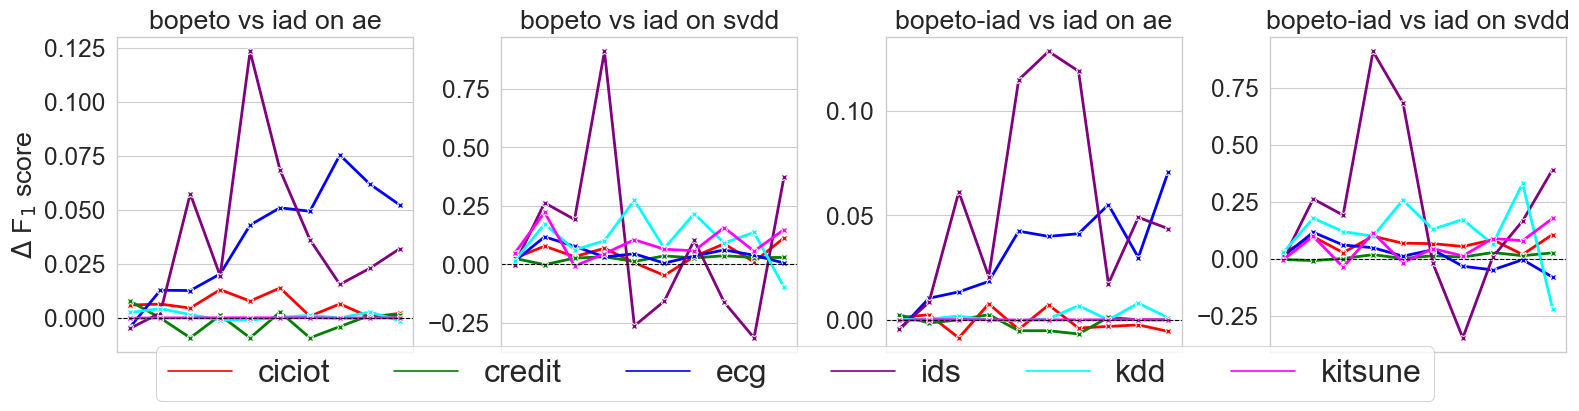

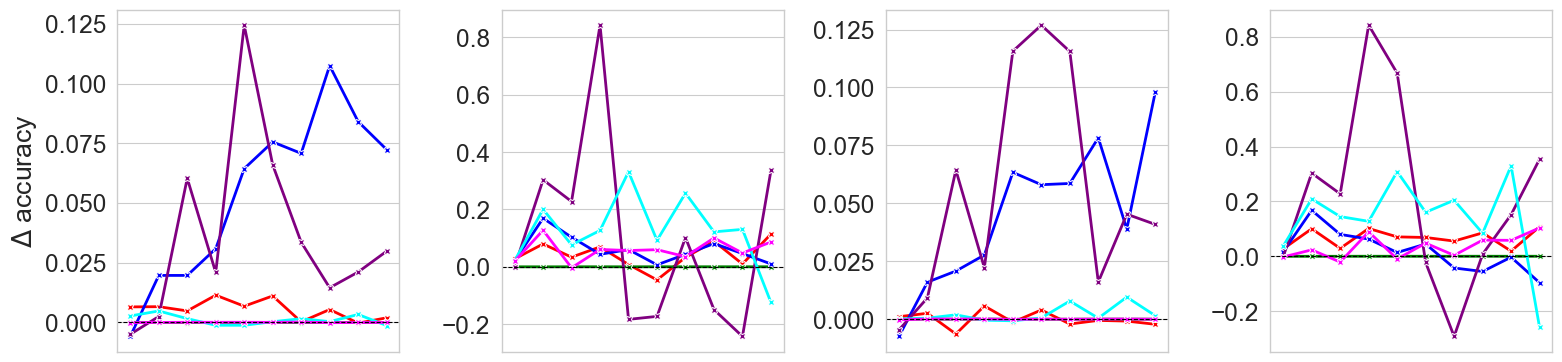

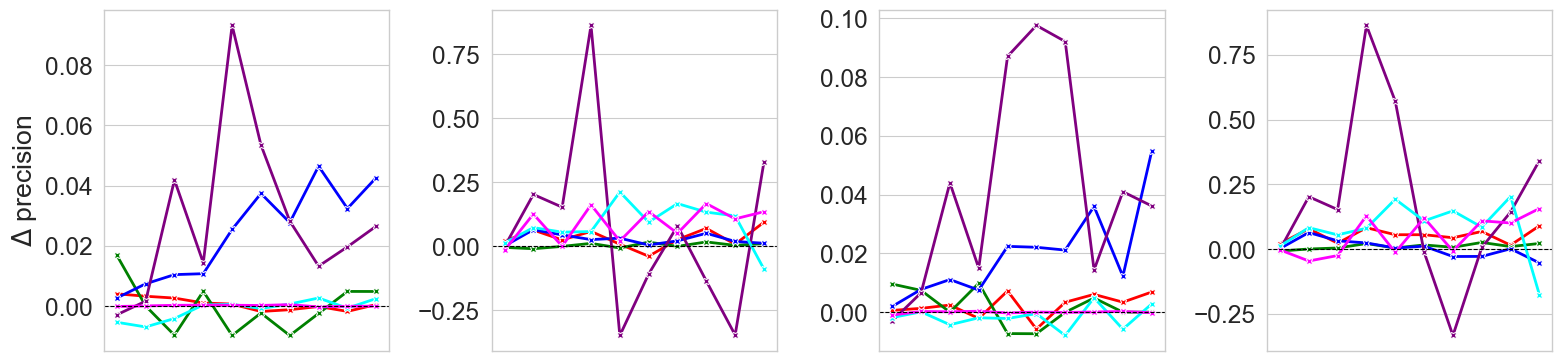

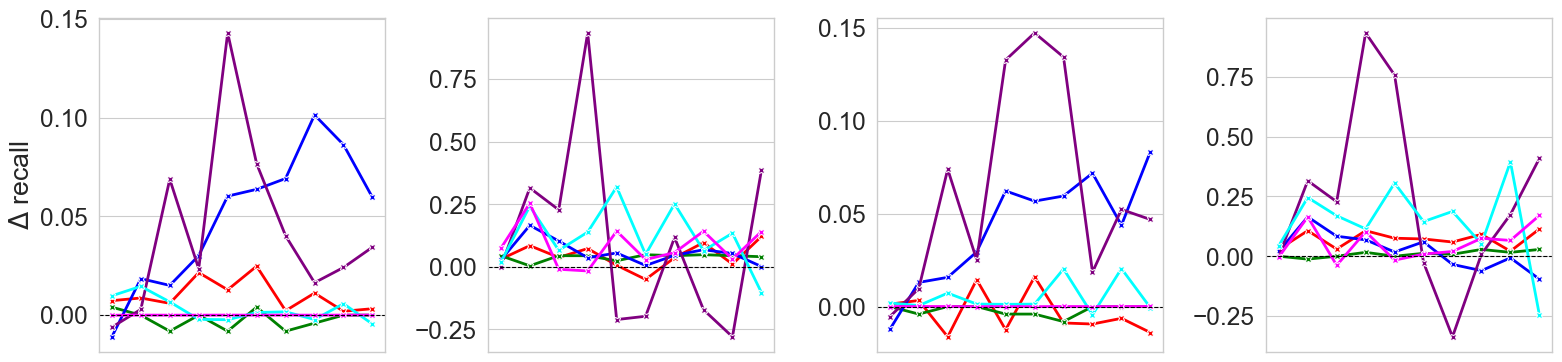

In [122]:
figsize = (16, 4)
k = True
for metric in performance_metrics:
    diff = diff_iad[diff_iad["metric"]==metric].sort_values(by=['dataset','contamination'])
    fig, axes = plt.subplots(ncols=4, figsize=figsize, sharey=False)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, diff.groupby('model'))):
        sns.lineplot(data=df_group, x=df_group.id, y="performance", hue='dataset', linewidth=2., ax=ax, marker='X', palette=palette_dataset)
        if metric=="f1":
            ax.set_title(f'{subplot}')
        ax.set_xlabel('')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        ax.set_xticks([])
        if i==0:
            if metric=="f1":
                ax.set_ylabel(r'$\Delta$ F$_1$ score')
                fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.09), ncol=6, fontsize='large')
                fig.tight_layout()
            else: 
                if i == 0:
                    ax.set_ylabel(r'$\Delta$ {}'.format(metric))
        else:
            ax.set_ylabel('')
        ax.legend().remove()
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    if k:
        pass
        #fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.21), ncol=6)
    k = False
    plt.tight_layout()
    plt.savefig(metric+"_iad_difference.pdf")
    plt.show()

In [ ]:
figsize = (16, 4)
k = True
for metric in performance_metrics:
    diff = diff_iad[diff_iad["metric"]==metric].sort_values(by=['dataset','contamination'])
    fig, axes = plt.subplots(ncols=4, figsize=figsize, sharey=False)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, diff.groupby('model'))):
        sns.boxplot(data=df_group, x=df_group.dataset, y="performance", ax=ax, palette=palette_dataset)
        #if metric=="f1":
            #ax.set_title(f'{subplot}')
        ax.set_xlabel('')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        #ax.set_xticks([])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        if i==0:
            if metric=="f1":
                ax.set_ylabel(r'$\Delta$ F$_1$ score')
                #fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.09), ncol=6, fontsize='large')
                fig.tight_layout()
            else: 
                if i == 0:
                    ax.set_ylabel(r'$\Delta$ {}'.format(metric))
        else:
            ax.set_ylabel('')
        #ax.legend().remove()
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    if k:
        pass
        #fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.21), ncol=6)
    k = False
    plt.tight_layout()
    plt.savefig(metric+"_boxplot_iad_difference.pdf")
    plt.show()

In [ ]:
values_iad = ["Bopeto_ae", "Bopeto_svdd", "iad_svdd", "iad_ae"]
values_bopeto_iad = ["iad_Bopeto_ae", "iad_Bopeto_svdd", "iad_svdd", "iad_ae"]
values = [values_iad, values_bopeto_iad]
keys = ["iad", "bopeto"]
for k, v in enumerate(values):
    for metric in performance_metrics:
        degration = df_iad[df_iad["model"].isin(v)]
        fig, axes = plt.subplots(ncols=6, figsize=(12, 2.7), sharey=False)
        for i, (ax, (subplot, df_group)) in enumerate(zip(axes, degration.groupby('dataset'))):
            sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X', palette=palette_model)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks([])
            if metric=="f1":
                if k==0:
                    ax.set_title(f'{subplot}')
                if i == 0:
                    ax.set_ylabel(r'F$_1$ score')
                    fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=8)
            else:
                if i == 0:
                    ax.set_ylabel(metric)
            ax.legend().remove()
        plt.tight_layout()
        plt.savefig(keys[k]+"_degration_"+metric+".pdf")
        plt.show()

### Statistics

In [ ]:
stat_perf = df_perf.copy()
stat_perf['bopeto'] = 0
stat_perf.loc[stat_perf['model'].str.contains("Bopeto"), 'bopeto'] = 1
stat_perf.head()

In [ ]:
stat_perf = stat_perf.drop_duplicates()
stat_perf = stat_perf.sort_values(by=['bopeto', 'contamination', 'model', 'dataset'])
stat_perf

In [ ]:
def prep_stat(metric):
    stat_db = pd.DataFrame([], columns=[metric])
    stat_db_b = pd.DataFrame([], columns=[metric])
    for dataset in datasets:
        for model in base_models:
            ds = stat_perf[(stat_perf["dataset"]==dataset) & (stat_perf["model"]==model)]
            ds_b = stat_perf[(stat_perf["dataset"]==dataset) & (stat_perf["model"]=="Bopeto_"+model)]
            contamination = np.unique(ds["contamination"][(ds["model"]==model) & (ds["dataset"]==dataset)].values)
            stat = []
            stat_b = []
            for c in contamination:
                m_b = ds_b.loc[ds_b['contamination']==c, metric].values[0]
                m = ds.loc[ds['contamination']==c, metric].values[0]
                stat.append(m)
                stat_b.append(m_b)
            stat_db = pd.concat([stat_db, pd.DataFrame({metric: stat})], ignore_index=True)
            stat_db_b = pd.concat([stat_db_b, pd.DataFrame({metric: stat_b})], ignore_index=True)
    return stat_db, stat_db_b

In [ ]:
for metric in performance_metrics:
    stat, stat_b = prep_stat(metric)
    statistic, p_value = wilcoxon(stat[metric].values, stat_b[metric].values)
    cohen_d = pg.compute_effsize(stat_b[metric].values, stat[metric].values, eftype='cohen')
    print(metric, "==>", "p_value = {}, effect size = {}".format(p_value, cohen_d))

In [ ]:
sub_df = {'ciciot':100*ciciot['r1'].values, 'credit':100*credit['r1'].values,
          'ecg':100*ecg['r1'].values, 'ids':100*ids['r1'].values,
    'kdd':100*kdd['r1'].values, 'kitsune':100*kitsune['r1'].values}

In [ ]:
keys = list(sub_df.keys())
for key in keys:
    sub_df[key] = np.diff(sub_df[key])
contaminations = {}
size = len(sub_df["ciciot"])
for i in range(size):
    contaminations[i] = [sub_df["ciciot"][i], sub_df["credit"][i], sub_df["ecg"][i], 
           sub_df["ids"][i], sub_df["kdd"][i], sub_df["kitsune"][i]]
 

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
width = 0.5
bottom = np.zeros(6) 
for boolean, weight_count in contaminations.items():
    p = ax[0].bar(keys, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count
ax[0].set_ylabel('contamination ratio (%)')
ax[0].legend().remove()
ax[0].set_xticklabels(keys, rotation=90)


sns.lineplot(data=data_cp, x=data_cp.id, y=data_cp.improvement, hue='dataset', ax=ax[1], marker='X', palette=palette_dataset)
#ax.set_title(f'{subplot}'.upper())
ax[1].set_xlabel('ith contamination') 
ax[2].set_ylabel('size of cleaned data (%)')
sns.lineplot(data=data, x=data.id, y=100*data.ratio, hue='dataset', ax=ax[2], marker='X', palette=palette_dataset)
ax[2].set_xlabel('ith contamination') 
ax[1].set_ylabel('contamination reduction (%)')
ax[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax[1].legend().remove()
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[1].set_ylim(-10, 110)
ax[2].set_ylim(-10, 110)
plt.tight_layout()
plt.savefig("cleaning_ratio.pdf")
plt.show()

In [ ]:
for metric in performance_metrics:
    degration = df_perf[~df_perf['model'].str.contains('Bopeto')]
    fig, axes = plt.subplots(ncols=6, figsize=(12, 2.7), sharey=False)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, degration.groupby('dataset'))):
        sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X', palette=palette_model)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        if metric=="f1":
            ax.set_title(f'{subplot}')
            if i==0:
                ax.set_ylabel(r'F$_1$ score')
                fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=8)
        else:
            if i==0:
                ax.set_ylabel(metric)
        #ax.set_ylim(-0.1, 1.1)
        ax.legend().remove()
    plt.tight_layout()
    plt.savefig("degration_"+metric+".pdf")
    plt.show()

In [ ]:
values_to_discard_1 = ["alad", "dagmm", "dsebm", "ae", "svdd","Bopeto_alad", "Bopeto_dagmm", 
                    "Bopeto_dsebm", "Bopeto_svdd", "Bopeto_ae"]
values_to_discard_2 = ["lof", "if", "ocsvm", "ae", "svdd", "Bopeto_if", "Bopeto_lof", 
                    "Bopeto_ocsvm", "Bopeto_ae", "Bopeto_svdd"]
values_to_discard_3 = ["Bopeto_alad", "Bopeto_dagmm", "Bopeto_dsebm", "Bopeto_if", "Bopeto_lof", 
                    "Bopeto_ocsvm", "Bopeto_ae", "Bopeto_svdd"]
values_to_discard_4 = ["dsebm", "Bopeto_dsebm"]
degration = df_perf[df_perf['model'].str.contains('Bopeto')]
degration = df_perf[df_perf['model'].isin(values_to_discard_3)]
for metric in performance_metrics:
    fig, axes = plt.subplots(ncols=6, figsize=(12, 2.7), sharey=False)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, degration.groupby('dataset'))):
        sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X', palette=palette_model)
        ax.set_xlabel('')
        ax.set_xticks([])
        ax.set_ylabel('')
        if metric=="f1":
            ax.set_title(f'{subplot}')
            if i==0:
                ax.set_ylabel(r'F$_1$ score')
                fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=8)
        else:
            if i == 0:
                ax.set_ylabel(metric)
        #ax.set_ylim(-0.1, 1.1)
        ax.legend().remove()
    plt.tight_layout()
    plt.savefig("Bopeto_value_"+metric+".pdf")
    plt.show()

In [ ]:
degration_perf = df_perf[~df_perf['model'].str.contains('Bopeto')]
degration_perf.groupby('dataset')['accuracy'].agg(['mean', 'std'])

In [ ]:
df_perf[df_perf['contamination']==0].head(10)

In [ ]:
def sort_group(group):
    return group.sort_values(by='dataset')

In [ ]:
df_perf.head()

In [ ]:
df_perf[(df_perf["dataset"]=="kdd") & (df_perf["model"]=="alad")]

In [ ]:
def get_diff(model, dataset):
    n_db = pd.DataFrame([])
    ds = df_perf[(df_perf["dataset"]==dataset) & (df_perf["model"]==model)]
    ds_b = df_perf[(df_perf["dataset"]==dataset) & (df_perf["model"]=="Bopeto_"+model)]
    contamination = np.unique(ds["contamination"].values)
    diff_acc = []
    diff_f1 = []
    diff_prec = []
    diff_rec = []
    for c in contamination:
        acc = ds_b.loc[ds_b['contamination']==c, "accuracy"].values[0]
        acc -= ds.loc[ds['contamination']==c, "accuracy"].values[0]
        diff_acc.append(acc)
        f1 = ds_b.loc[ds_b['contamination']==c, "f1"].values[0]
        f1 -= ds.loc[ds['contamination']==c, "f1"].values[0]
        diff_f1.append(f1)
        prec = ds_b.loc[ds_b['contamination']==c, "precision"].values[0]
        prec -= ds.loc[ds['contamination']==c, "precision"].values[0]
        diff_prec.append(prec)
        rec = ds_b.loc[ds_b['contamination']==c, "recall"].values[0]
        rec -= ds.loc[ds['contamination']==c, "recall"].values[0]
        diff_rec.append(rec)
    n_db["accuracy"] = diff_acc
    n_db["precision"] = diff_prec
    n_db["f1"] = diff_f1
    n_db["recall"] = diff_rec
    n_db["contamination"] = contamination
    n_db["dataset"]=dataset
    n_db["model"] = model
    n_db["id"]=range(len(contamination))
    return n_db
    

In [ ]:
get_diff("dagmm", "ecg")

In [ ]:
difference = pd.DataFrame([])
for d_name in datasets:
    for m_name in base_models:
        difference = pd.concat([difference, get_diff(m_name, d_name.lower())], ignore_index=True)

In [ ]:
figsize = (21, 3)
k = True
sns.set_context("paper", font_scale=2.)  # Adjust font scale
sns.set_style("whitegrid") 
for metric in performance_metrics:
    robustness = difference.sort_values(by=['dataset','contamination'])
    fig, axes = plt.subplots(ncols=7, figsize=figsize, sharey=False)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, robustness.groupby('model'))):
        sns.lineplot(data=df_group, x=df_group.id, y=metric, hue='dataset', linewidth=2., ax=ax, marker='X', palette=palette_dataset)
        if metric=="f1":
            ax.set_title(f'{subplot}')
        ax.set_xlabel('')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        ax.set_xticks([])
        if i==0:
            if metric=="f1":
                ax.set_ylabel(r'$\Delta$ F$_1$ score')
                fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.1), ncol=6, fontsize='large')
                fig.tight_layout()
            else: 
                if i == 0:
                    ax.set_ylabel(r'$\Delta$ {}'.format(metric))
        else:
            ax.set_ylabel('')
        ax.legend().remove()
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    if k:
        pass
        #fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.21), ncol=6)
    k = False
    plt.tight_layout()
    plt.savefig(metric+"_difference.pdf")
    plt.show()

In [ ]:
figsize = (16, 4)
k = True
for metric in performance_metrics:
    diff = difference.sort_values(by=['dataset','contamination'])
    fig, axes = plt.subplots(ncols=7, figsize=figsize, sharey=False)
    for i, (ax, (subplot, df_group)) in enumerate(zip(axes, diff.groupby('model'))):
        sns.boxplot(data=df_group, x=df_group.dataset, y=metric, ax=ax, palette=palette_dataset)
        #if metric=="f1":
            #ax.set_title(f'{subplot}')
        ax.set_xlabel('')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        #ax.set_xticks([])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        if i==0:
            if metric=="f1":
                ax.set_ylabel(r'$\Delta$ F$_1$ score')
                #fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.09), ncol=6, fontsize='large')
                fig.tight_layout()
            else: 
                if i == 0:
                    ax.set_ylabel(r'$\Delta$ {}'.format(metric))
        else:
            ax.set_ylabel('')
        #ax.legend().remove()
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    if k:
        pass
        #fig.legend(loc='lower center', bbox_to_anchor=(.5, -0.21), ncol=6)
    k = False
    plt.tight_layout()
    plt.savefig(metric+"_boxplot_bop_difference.pdf")
    plt.show()

In [ ]:
def swap_prefix(name):
    if '_' in name:
        parts = name.split('_')
        return f"{parts[1]}_{parts[0]}"
    else:
        return name

In [ ]:
def get_detail_summary(df_perf, metric):
    grouped_perf = df_perf.groupby(['model', 'dataset']).agg({metric: ['mean', 'std']})
    grouped_perf.columns = ['_'.join(col).strip() for col in grouped_perf.columns.values]
    grouped_perf[metric+'_mean'] = grouped_perf[metric+'_mean'].round(3)
    grouped_perf[metric+'_std'] = grouped_perf[metric+'_std'].round(3)
    grouped_perf[metric] = grouped_perf[metric+'_mean'].astype(str) + ' ± ' + grouped_perf[metric+'_std'].astype(str)
    pivot_df = grouped_perf.reset_index().pivot(index='model', columns='dataset', values=metric)
    pivot_df.rename(index=lambda x: swap_prefix(x), inplace=True)
    pivot_df.sort_index(inplace=True)
    return pivot_df

In [ ]:
def remove_sign(value):
    if isinstance(value, str):
        parts = value.split(' ± ')
        if len(parts) > 1:
            return float(parts[0])  # Convert the value to float
    return value

In [ ]:
def get_general_summary(df):
    data = df.applymap(remove_sign)
    df_basic = data[~data.index.str.contains('Bopeto')] 
    df_basic.sort_index(inplace=True)
    df_bopeto = data[data.index.str.contains('Bopeto')] 
    df_bopeto.sort_index(inplace=True)
    diff = df_bopeto.values - df_basic.values
    return pd.DataFrame(data=diff, index=df_basic.index, columns=df_basic.columns)

In [ ]:
def get_latex(df, metric):
    return df.to_latex(index=False, 
                          caption='Example Table', 
                          label='tab:summary_'+metric, 
                          column_format='|c|c|c|c|c|c|c|')

In [ ]:
f1_df = get_detail_summary(df_perf, "f1")
f1_df

In [ ]:
print(get_latex(f1_df, "f1"))

In [ ]:
gen = get_general_summary(f1_df)
gen.stack().mean(), gen.stack().std()

In [ ]:
gen.gt(0).mean()

In [ ]:
prec_df = get_detail_summary(df_perf, "precision")
prec_df

In [ ]:
gen = get_general_summary(prec_df)
gen.stack().mean(), gen.stack().std()

In [ ]:
gen.gt(0).mean()

In [ ]:
rec_df = get_detail_summary(df_perf, "recall")
rec_df

In [ ]:
gen = get_general_summary(rec_df)
gen.stack().mean(), gen.stack().std()

In [ ]:
gen.gt(0).mean()

In [ ]:
acc_df = get_detail_summary(df_perf, "accuracy")
acc_df

In [ ]:
gen = get_general_summary(acc_df)
gen.stack().mean(), gen.stack().std()

In [ ]:
gen.gt(0).mean()

In [ ]:
for metric in performance_metrics:
    for model in base_models:
        palette ={'Bopeto_'+model: 'blue', model: 'red'}
        robustness = df_perf[df_perf['model'].str.contains(model)]
        robustness = robustness.sort_values(by='dataset')
        fig, axes = plt.subplots(ncols=6, figsize=(9, 2), sharey=True)
        for i, (ax, (subplot, df_group)) in enumerate(zip(axes, robustness.groupby('dataset'))):
            sns.lineplot(data=df_group, x=df_group.contamination, y=metric, hue='model', ax=ax, marker='X', palette=palette)
            ax.set_title(f'{subplot}'.upper())
            ax.set_xlabel('')
            if metric=="f1":
                ax.set_ylabel(r'F$_1$ score')
            else:
                ax.set_ylabel(metric)
            ax.set_ylim(-0.1, 1.1)

            if i != 0:
                ax.legend().remove()
            else:
                ax.legend(loc='lower center', bbox_to_anchor=(2.5, -0.35), ncol=2)
        plt.tight_layout()
        plt.savefig(model+"_"+metric+"_robustness.pdf")
        plt.show()

In [ ]:
load_ciciot = np.load("../data/ciciot.npz", allow_pickle=True) 
load_credit = np.load("../data/credit.npz", allow_pickle=True) 
load_ecg = np.load("../data/ecg.npz", allow_pickle=True) 
load_ids = np.load("../data/ids.npz", allow_pickle=True) 
load_kdd = np.load("../data/kdd.npz", allow_pickle=True) 
load_kitsune = np.load("../data/kitsune.npz", allow_pickle=True) 
data1_ciciot = pd.DataFrame(load_ciciot['ciciot'])
data1_credit = pd.DataFrame(load_credit['credit'])
data1_ecg = pd.DataFrame(load_ecg['ecg'])
data1_ids = pd.DataFrame(load_ids['ids'])
data1_kdd = pd.DataFrame(load_kdd['kdd'])
data1_kitsune = pd.DataFrame(load_kitsune['kitsune'])

In [ ]:
all_datasets = [data1_ciciot, data1_credit, data1_ecg, data1_ids, data1_kdd, data1_kitsune]
pca = PCA(n_components=2)
fig, axs = plt.subplots(1, 6, figsize=(20, 5))
for i, xy in enumerate(all_datasets):
    xy = xy.sample(n=min(10000, len(xy)))
    x, y = xy.values[:, :-1], xy.values[:, -1]
    reduced_data = pca.fit_transform(x)
    y = y.reshape(-1, 1)
    reduced_data = np.hstack((reduced_data, y))
    df_pca = pd.DataFrame(reduced_data, columns=['x1', 'x2', 'target'])
    # df_pca = pd.DataFrame(reduced_data, columns=columns)
    df_pca['target'] = df_pca['target'].map(instance_mapping)
    sns.scatterplot(data=df_pca, x='x1', y='x2', hue='target', ax=axs[i], palette=palette_instance, legend=(i==0))
    axs[i].set_title(datasets[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    if i == 0:
        axs[i].legend(title='')
    else:
        axs[i].legend([],[], frameon=False)

plt.tight_layout()
plt.savefig("synthetic.png")
plt.show()


In [ ]:
def sdc(dynamics):
    return np.std(np.diff(dynamics, axis=1), axis=1)

In [ ]:
def extract_data(path):
    raw = np.load(path, allow_pickle=True)
    keys = list(raw.keys())
    train = raw[keys[-2]]
    weights = raw[keys[-1]]
    hard = weights[:, 0]
    soft = weights[:, 1]
    y = train[:, -1]
    x = train[:, :-1]
    threshold = np.min(soft[hard==1])
    return x, hard, soft, y, threshold

def extract_data_2(path):
    raw = np.load(path, allow_pickle=True)
    keys = list(raw.keys())
    train = raw[keys[-1]]
    weights = raw[keys[0]]
    hard = weights[:, 0]
    y = train[:, -1]
    x = train[:, :-1]
    return x, hard, y   

In [ ]:
x_ciciot, hard_ciciot, y_ciciot = extract_data_2("../detection/ciciot_fp.npz")
x_credit, hard_credit, y_credit = extract_data_2("../detection/credit_fp.npz")
x_kdd, hard_kdd, y_kdd = extract_data_2("../detection/kdd_fp.npz")
x_kitsune, hard_kitsune, y_kitsune = extract_data_2("../detection/kitsune_fp.npz")
x_ids, hard_ids, y_ids = extract_data_2("../detection/ids_fp.npz")
x_ecg, hard_ecg, y_ecg = extract_data_2("../detection/ecg_fp.npz")

In [ ]:
pca = PCA(n_components=2)
def annotation(x, y, w):
    label = [0 if y[i]==0 and w[i]==1 else 1 if y[i]==1 and w[i]==0 else 2 
     if y[i]==0 and w[i]==0 else 3 for i in range(len(x))]
    label = np.array(label).reshape(-1, 1)
    x = pca.fit_transform(x)
    xy = np.hstack((x, label))
    df = pd.DataFrame(data = xy, columns=["x1", "x2", "label"])
    df['label'] = df['label'].replace(false_mapping)
    return df

In [ ]:
ann_kdd = annotation(x_kdd, y_kdd, hard_kdd)
ann_kitsune = annotation(x_kitsune, y_kitsune, hard_kitsune)
ann_ids = annotation(x_ids, y_ids, hard_ids)
ann_ecg = annotation(x_ecg, y_ecg, hard_ecg)
ann_credit = annotation(x_credit, y_credit, hard_credit)
ann_ciciot = annotation(x_ciciot, y_ciciot, hard_ciciot)

In [ ]:
ann_kdd[["x1", "x2"]].head()

In [ ]:
annotations = [ann_ciciot, ann_credit, ann_ecg, ann_ids, ann_kdd, ann_kitsune]
num_matrices = len(annotations)
num_sequences = 100
sequence_length = 50
num_categories = 4
fig, axes = plt.subplots(1, 6, figsize=(9, 2), sharey=False)
for i, df in enumerate(annotations):
    ax = axes[i]
    df = df.sample(n=min(len(df), 5000))
    pca = PCA(n_components=1)
    one_dim = pca.fit_transform(df[["x1", "x2"]].values)
    df["x"] = one_dim
    sns.scatterplot(data=df, x=df.x1, y=df.x2, hue='label', ax=ax, palette=false_palette, s=10)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(datasets[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend().remove()
       
    if i==0:
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4)
        fig.tight_layout()
        
    
plt.tight_layout()
plt.savefig("fp_distribution.png")
plt.show()
 

In [ ]:
x_kdd, hard_kdd, soft_kdd, y_kdd, threshold_kdd = extract_data("../detection/kdd_plot.npz")
x_kitsune, hard_kitsune, soft_kitsune, y_kitsune, threshold_kitsune = extract_data("../detection/kitsune_plot.npz")
x_ids, hard_ids, soft_ids, y_ids, threshold_ids = extract_data("../detection/ids_plot.npz")
x_ecg, hard_ecg, soft_ecg, y_ecg, threshold_ecg = extract_data("../detection/ecg_plot.npz")
x_credit, hard_credit, soft_credit, y_credit, threshold_credit = extract_data("../detection/credit_plot.npz")
x_ciciot, hard_ciciot,soft_ciciot, y_ciciot, threshold_ciciot = extract_data("../detection/ciciot_plot.npz")

In [ ]:
softs = [soft_ciciot, soft_credit, soft_ecg, soft_ids, soft_kdd, soft_kitsune]
ys = [y_ciciot, y_credit, y_ecg, y_ids, y_kdd, y_kitsune]
thresholds =[threshold_ciciot, threshold_credit-0.5, threshold_ecg, threshold_ids, threshold_kdd, threshold_kitsune-0.3]

In [ ]:
out = "../outputs_backup_01/"
kdd_1 = np.loadtxt(out+"kdd_FGM_sdc_ae_rate_0.18821442994855225.csv", delimiter=',')
ids_1 = np.loadtxt(out+"ids_FGM_sdc_ae_rate_0.15585998801128825.csv", delimiter=',')
credit_1 = np.loadtxt(out+"credit_FGM_sdc_ae_rate_0.0012223312434517968.csv", delimiter=',')
ecg_1 = np.loadtxt(out+"ecg_FGM_sdc_ae_rate_0.21916092673763307.csv", delimiter=',')
ciciot_1 = np.loadtxt(out+"ciciot_FGM_sdc_ae_rate_0.19310100024086915.csv", delimiter=',')
kitsune_1 = np.loadtxt(out+"kitsune_FGM_sdc_ae_rate_0.0701628076642476.csv", delimiter=',')

In [ ]:
x_kdd, y_kdd = kdd_1[:, :-1], kdd_1[:, -1]
x_ids, y_ids = ids_1[:, :-1], ids_1[:, -1]
x_ciciot, y_ciciot = ciciot_1[:, :-1], ciciot_1[:, -1]
x_kitsune, y_kitsune = kitsune_1[:, :-1], kitsune_1[:, -1]
x_credit, y_credit = credit_1[:, :-1], credit_1[:, -1]
x_ecg, y_ecg = ecg_1[:, :-1], ecg_1[:, -1]

In [ ]:
m = 'score'
mac_kdd = sdc(x_kdd)
mac_ids = sdc(x_ids)
mac_ciciot = sdc(x_ciciot)
mac_kitsune = sdc(x_kitsune)
mac_credit = sdc(x_credit)
mac_ecg = sdc(x_ecg)

In [ ]:
def clean(dynamics, target, n=1000):
    detector = IsolationForest(n_estimators=50, random_state=42)
    df = pd.DataFrame(data = dynamics, columns=[m])
    df['class'] = target
    df['class'] = df['class'].replace(instance_mapping)
    y_pred = detector.fit_predict(dynamics.reshape(-1, 1))
    anomaly_scores = detector.decision_function(dynamics.reshape(-1, 1))
    out = anomaly_scores[y_pred==-1]
    in_ = anomaly_scores[y_pred==1]
    threshold = (np.max(out)+np.min(in_))/2
    threshold = np.percentile(out, np.random.randint(60, 70, 1)[0])
    y_pred = anomaly_scores >= threshold

    df[m] = anomaly_scores
    y = y_pred==1
    sample = df.sample(n=n)
    selected = df.index.isin(sample.index)
    cleaned = df[y & selected].copy()
    return sample, cleaned, threshold 

In [ ]:
all_data = [clean(mac_ciciot, y_ciciot), clean(mac_credit, y_credit), 
            clean(mac_ecg, y_ecg), clean(mac_ids, y_ids), 
            clean(mac_kdd, y_kdd), clean(mac_kitsune, y_kitsune)]


In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(9, 3))
for i, df in enumerate(all_data):
    df_soft = pd.DataFrame(data = softs[i], columns=["weight"])
    df_soft['class'] = ys[i].astype(int)
    df_soft['class'] = df_soft['class'].replace(instance_mapping)
    if i==1:
        anomalies = df_soft[df_soft['class']=='out'].sample(n=28,replace=False)
        df_soft = df_soft.sample(n=600,replace=False)
        df_soft = pd.concat([df_soft,anomalies], axis=0, ignore_index=True)
        df_soft = df_soft.sample(frac = 1)
        df_soft.reset_index(drop=True, inplace=True)
    else:
        df_soft = df_soft.sample(n=1400,replace=False)
    for j in range(1):
        d = df[j]
        d = d.sort_index()
        ax = axes[0, i]
        
        sns.scatterplot(data=df_soft, x=df_soft.index, y="weight", hue='class', ax=ax, palette=palette_instance, s=10)
        ax.axhline(y=thresholds[i], color='r', linestyle='-')
        ax.set_ylabel(None)
        if j==0:
            ax.set_title(datasets[i])
        if i!=0 or j!=1:
            ax.legend().remove()
        else:
            legend = ax.legend()
            if legend:
                for label in legend.get_texts():
                    label.set_fontsize('xx-small')
        
        
        ax.set_xticks([])
        ax = axes[1, i]
        sns.kdeplot(data= d, x='score', hue='class', fill=True, ax=ax, palette=palette_instance)
        ax.legend().remove()
        ax.set_xticks([])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        if i!=0:
            axes[0, i].set_ylabel('')
            axes[1, i].set_ylabel('')
        else:
            pass
            #axes[1, 0].set_ylabel('density')
        ax.set_ylim(0, 16)
plt.tight_layout()
plt.savefig("dynamics_space.png")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data: 6 sequence matrices with three categories
num_matrices = 6
num_sequences = 100
sequence_length = 50
num_categories = 3

sequences = [x_ciciot, x_credit, x_ecg, x_ids, x_kdd, x_kitsune]
labels = [y_ciciot, y_credit, y_ecg, y_ids, y_kdd, y_kitsune]
fig, axs = plt.subplots(1, 6, figsize=(9, 2), sharex=True)
sequence_length = 10
for i in range(6):
    seq = sequences[i]
    lab = labels[i]
    print(i, seq.shape)
    print(i, lab.shape)
    for j, instance in enumerate(palette_instance):
        color = palette_instance[instance]
        k = 0 if instance =="in" else 1 if instance=='out' else 2
        cat_sequences = seq[lab == k]
        mean_sequence = np.mean(cat_sequences, axis=0)
        std_sequence = np.std(cat_sequences, axis=0)
        print("mean",mean_sequence)
        print("std", std_sequence)
        axs[i].plot(mean_sequence, color=color, label=instance)
        axs[i].fill_between(range(sequence_length), mean_sequence - std_sequence, mean_sequence + std_sequence, color=color, alpha=0.2)
plt.tight_layout()
plt.savefig("dynamics_space_two.png")
plt.show()
